<a href="https://colab.research.google.com/github/daspartho/fastai-part2/blob/main/matmul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Get Data

In [188]:
from pathlib import Path
import pickle, gzip, os
import matplotlib as mpl
import matplotlib.pyplot as plt

In [189]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

In [190]:
from urllib.request import urlretrieve
if not path_gz.exists():
    urlretrieve(MNIST_URL, path_gz)

In [191]:
!ls -l data

total 16656
-rw-r--r-- 1 root root 17051982 Oct 28 18:39 mnist.pkl.gz


In [192]:
with gzip.open(path_gz, 'rb') as f:
    (x_train, y_train), (x_valid, y_valid), _ = pickle.load(f, encoding='latin-1')

In [193]:
type(x_train)

numpy.ndarray

In [194]:
ls1 = list(x_train[0])
vals = ls1[200:210]
vals

[0.0,
 0.0,
 0.0,
 0.19140625,
 0.9296875,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125]

In [195]:
def chunks(x, sz):
    for i in range(0, len(x), sz):
        yield x[i: i+sz]

In [196]:
type(chunks(vals, 5))

generator

In [197]:
list(chunks(vals, 5))

[[0.0, 0.0, 0.0, 0.19140625, 0.9296875],
 [0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]]

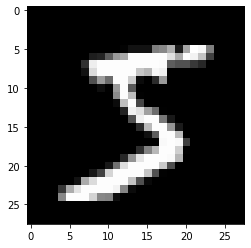

In [198]:
mpl.rcParams['image.cmap'] = 'gray'
plt.imshow(list(chunks(ls1, 28)))

In [199]:
from itertools import islice

In [200]:
it = iter(vals)
it

In [201]:
list(islice(it, 5))

[0.0, 0.0, 0.0, 0.19140625, 0.9296875]

In [202]:
it = iter(ls1)
img = list(iter(lambda: list(islice(it, 28)), []))

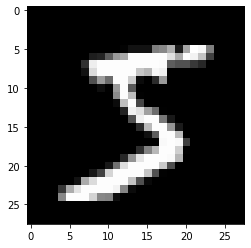

In [203]:
plt.imshow(img)

### Matrix and Tensor

In [204]:
img[20][15]

0.98828125

In [205]:
class Matrix:
    def __init__(self, xs):
        self.xs = xs
    def __getitem__(self, idxs):
        return self.xs[idxs[0]][idxs[1]]

In [206]:
m = Matrix(img)
m[20, 15]

0.98828125

In [207]:
import torch
from torch import tensor

In [208]:
tensor(vals)

tensor([0.0000, 0.0000, 0.0000, 0.1914, 0.9297, 0.9883, 0.9883, 0.9883, 0.9883,
        0.9883])

In [209]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
x_train.shape

torch.Size([50000, 784])

In [210]:
x_train.type()

'torch.FloatTensor'

In [211]:
imgs = x_train.reshape(-1, 28, 28)
imgs.shape

torch.Size([50000, 28, 28])

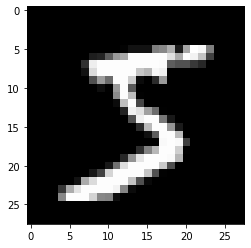

In [212]:
plt.imshow(imgs[0])

In [213]:
imgs[0,20,15]

tensor(0.9883)

In [214]:
y_train, y_train.shape

(tensor([5, 0, 4,  ..., 8, 4, 8]), torch.Size([50000]))

In [215]:
y_train.min(), y_train.max()

(tensor(0), tensor(9))

### Random Numbers

In [216]:
rnd_state = None
def seed(a):
    global rnd_state
    a, x = divmod(a, 30268)
    a, y = divmod(a, 30306)
    a, z = divmod(a, 30322)
    rnd_state = int(x)+1, int(y)+1, int(z)+1

In [217]:
seed(457428938475)
rnd_state

(4976, 20238, 499)

In [218]:
def rand():
    global rnd_state
    x, y, z = rnd_state
    x = (171 * x) % 30269
    y = (172 * y) % 30307
    z = (170 * z) % 30323
    rnd_state = x,y,z
    return (x/30269 + y/30307 + z/30323) % 1.0

In [219]:
rand(),rand(),rand()

(0.7645251082582081, 0.7920889799553945, 0.06912886811267205)

In [220]:
if os.fork(): 
    print(f'In parent: {rand()}')
else:
    print(f'In child: {rand()}')
    os._exit(os.EX_OK)

In parent: 0.9559050644103264
In child: 0.9559050644103264


In [221]:
if os.fork(): 
    print(f'In parent: {torch.rand(1)}')
else:
    print(f'In child: {torch.rand(1)}')
    os._exit(os.EX_OK)

In parent: tensor([0.1269])
In child: tensor([0.1269])


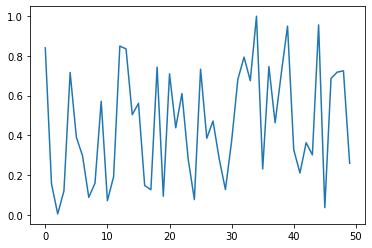

In [222]:
plt.plot([rand() for _ in range(50)])

(array([ 959.,  972., 1036., 1019., 1037.,  971.,  997., 1000., 1036.,
         973.]),
 array([6.60514437e-06, 1.00005135e-01, 2.00003666e-01, 3.00002196e-01,
        4.00000726e-01, 4.99999256e-01, 5.99997787e-01, 6.99996317e-01,
        7.99994847e-01, 8.99993378e-01, 9.99991908e-01]),
 <a list of 10 Patch objects>)

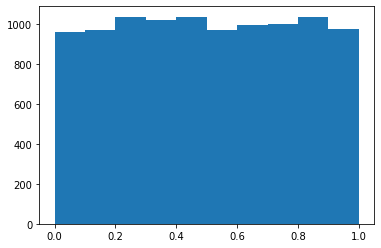

In [223]:
plt.hist([rand() for _ in range(10000)])

In [224]:
%timeit -n 10 list(chunks([rand() for _ in range(7840)], 10))

5.09 ms ± 304 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [225]:
%timeit -n 10 torch.randn(784,10)

66.8 µs ± 10.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Matrix Multiplication

In [226]:
weights = torch.randn(784, 10)
bias = torch.randn(10)

In [227]:
m1 = x_valid[:5]
m2 = weights
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [228]:
m1r, m1c = m1.shape
m2r, m2c = m2.shape

In [229]:
t1=torch.zeros(m1r, m2c)
t1.shape

torch.Size([5, 10])

In [230]:
t1

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [231]:
for i in range(m1r):
    for j in range(m2c):
        for k in range(m1c): # or m2r (both same)
            t1[i, j] += m1[i,k] * m2[k, j]

In [232]:
t1

tensor([[  1.7348,   2.4407,  10.9940,  -5.2744, -12.4304,  -8.8594,  -6.6233,
         -10.5295,  -1.8992,  -0.6338],
        [ 13.2959,   8.4160,   5.3741,  -0.8135, -17.4465,  -3.4685,   6.3011,
         -14.2091,  -9.3500, -17.4759],
        [  3.7037,   1.0089,  -1.6472,   9.4463,  -1.0321,  -0.4922,  -2.3505,
         -10.7572, -11.1882,   4.9924],
        [  6.6864,  13.2665, -11.2224,  -6.2310, -20.3358,   0.9853,  14.0568,
         -13.8845, -15.5842,  -5.6582],
        [  8.0917,   9.7304,   1.3109,  -8.0870,   5.7689,   2.1246, -11.9962,
          -5.7320,  -4.1243,  -4.8981]])

In [233]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): # or br (both same)
                c[i, j] += a[i,k] * b[k, j]
    return c

In [234]:
matmul(m1, m2)

tensor([[  1.7348,   2.4407,  10.9940,  -5.2744, -12.4304,  -8.8594,  -6.6233,
         -10.5295,  -1.8992,  -0.6338],
        [ 13.2959,   8.4160,   5.3741,  -0.8135, -17.4465,  -3.4685,   6.3011,
         -14.2091,  -9.3500, -17.4759],
        [  3.7037,   1.0089,  -1.6472,   9.4463,  -1.0321,  -0.4922,  -2.3505,
         -10.7572, -11.1882,   4.9924],
        [  6.6864,  13.2665, -11.2224,  -6.2310, -20.3358,   0.9853,  14.0568,
         -13.8845, -15.5842,  -5.6582],
        [  8.0917,   9.7304,   1.3109,  -8.0870,   5.7689,   2.1246, -11.9962,
          -5.7320,  -4.1243,  -4.8981]])

In [235]:
%time _=matmul(m1, m2)

CPU times: user 730 ms, sys: 3.32 ms, total: 733 ms
Wall time: 740 ms


### Numba

In [236]:
from numba import njit

In [237]:
@njit
def dot(a, b):
    res = 0
    for i in range(len(a)):
        res+= a[i]*b[i]
    return res

In [238]:
from numpy import array
a = array([1,2,3])
b = array([1,2,3])

In [239]:
%time dot(a, b)

CPU times: user 105 ms, sys: 1.88 ms, total: 107 ms
Wall time: 109 ms


14

In [240]:
%time dot(a, b)

CPU times: user 13 µs, sys: 1 µs, total: 14 µs
Wall time: 16.7 µs


14

In [241]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            c[i, j] = dot(a[i,:],b[:,j])
    return c

In [242]:
m1a, m2a = m1.numpy(), m2.numpy()

In [243]:
from fastcore.test import *

In [244]:
test_close(t1, matmul(m1a, m2a))

In [245]:
%timeit -n 10 matmul(m1a, m2a)

429 µs ± 144 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
